In [1]:
import math
import torch
import ntwrk
from ntwrk.bayesopt import BayesOpt, expected_improvement, max_mean

import gym
import sys
sys.path.append("../../ntwrk/gym/")
import multi_sender_sim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
n_sender=2

In [3]:
env = gym.make("Sndr-v0")
env.reset(n_sender)

History length: 10
Features: ['sent latency inflation', 'latency ratio', 'send ratio']
Getting min obs for ['sent latency inflation', 'latency ratio', 'send ratio']
Reward: 0.00, Ewma Reward: 0.00


/home/vagrant/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


array([0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
       1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.])

In [4]:
max_x = 1000
n_start = 3
rates = torch.rand(n_sender, n_start, 1)
rwrds = torch.zeros(n_sender, n_start)
for rind in range(n_start):
    rwrds[:, rind] = torch.tensor(env.step(rates[:, rind, :].mul(max_x))[1])
    

In [5]:
rwrds

tensor([[-1.0158, -1.2492, -1.5133],
        [ 0.8283,  0.8436,  0.7992]])

In [6]:
BayesOpter = []
for sndr in range(n_sender):
    BayesOpter.append(BayesOpt(rates[sndr, :, 0].mul(max_x), rwrds[sndr, :], 
                              normalize=True, max_x=max_x, acquisition=expected_improvement,
                              max_jump=300))

tensor([[815.0057],
        [  0.0000]])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])


/home/vagrant/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/vagrant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


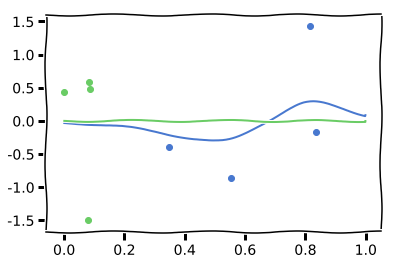

tensor([[809.9017],
        [235.1759]])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])


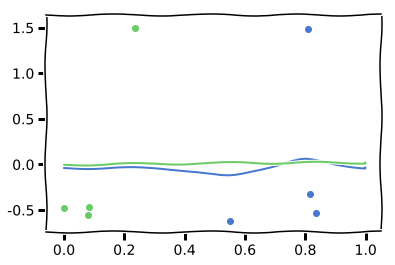

tensor([[958.1323],
        [239.3500]])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])


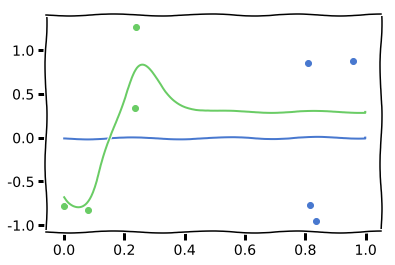

tensor([[958.7698],
        [246.6375]])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])


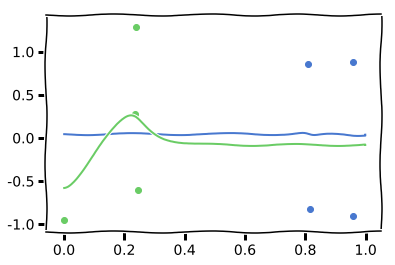

tensor([[658.7698],
        [230.7414]])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])


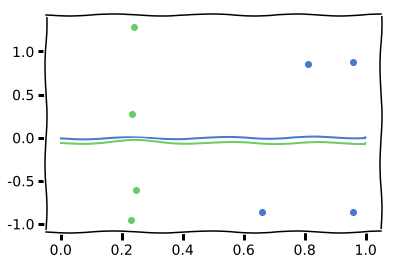

tensor([[913.5436],
        [458.7313]])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])


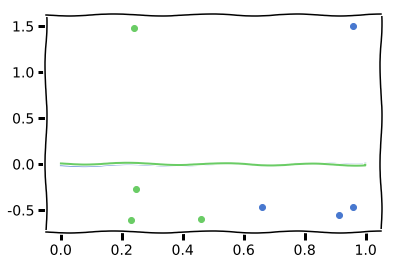

tensor([[935.9143],
        [158.7313]])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])


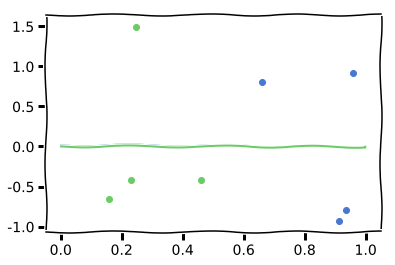

tensor([[657.8692],
        [  0.0000]])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])


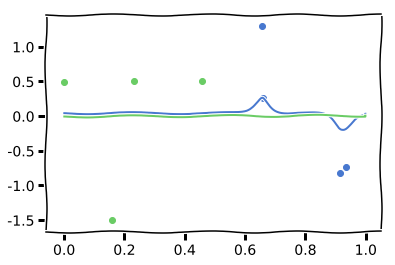

tensor([[653.3466],
        [300.0000]])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])


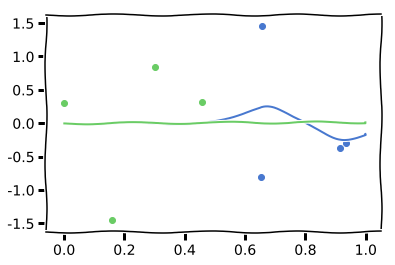

tensor([[353.3466],
        [482.4121]])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])


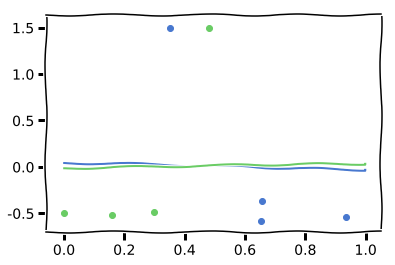

In [12]:
colors = sns.color_palette("muted")

rnds = 10
saved_rates = torch.zeros(rnds, n_sender, 1)
saved_rwrds = torch.zeros(rnds, n_sender)
test_points = torch.arange(1, 1000).float().div(max_x)


for ii in range(rnds):
    
    ## TRAIN MODELS AND ACQUIRE ##
    next_rates = torch.zeros(n_sender, 1)
    for sndr, bo in enumerate(BayesOpter):
        bo.train_surrogate(iters=250, overwrite=True)
        next_rates[sndr, 0] = bo.acquire(explore=0.1).item()
        
    ## save ##
    saved_rates[ii, :, :] = next_rates
#     print("next rate = ", next_rates)
    
    ## run the network ##
    print(next_rates)
    rwrds = torch.tensor(env.step(next_rates.mul(bo.max_x))[1])
    saved_rwrds[ii,:] = torch.tensor(rwrds)
    
    ## update observations
    for sndr, bo in enumerate(BayesOpter):
        new_x = next_rates[sndr, :].float().clone()
        new_y = rwrds[sndr].unsqueeze(-1).float().clone()
        
        print(new_x.shape)
        print(new_y.shape)
        bo.update_obs(new_x, new_y, max_obs=4)
        
    with plt.xkcd():
        for sndr in range(n_sender):
            pred_mean = BayesOpter[sndr].get_pred_dist(test_points).mean
            
            
#             plt.scatter(saved_rates[:ii, sndr, 0], saved_rwrds[:ii, sndr], 
#                         color=colors[sndr])

            plt.scatter(BayesOpter[sndr].train_x, BayesOpter[sndr].train_y,
                    color=colors[sndr])
            plt.plot(test_points, pred_mean.detach(),
                    color=colors[sndr])
        plt.show()